In [188]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, copy, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, json, regex as re
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label
from scipy.stats import mode
import joblib as jl
from plotnine import *
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests, fdrcorrection

import sys; sys.path.append('C:/Users/acorver/Documents/repositories/matplotlib-curly-brace/')
from curlyBrace import curlyBrace

import warnings
warnings.filterwarnings('ignore')

### Specify data files to display

In [8]:
fnames = [x for x in glob.glob('\\\\?\\Z:\\behavior\\*\\croprot\\*_dlc_abs_filt_interp_mvmt_noborder.npy') if 'RIG' not in x]
len(fnames)

40

In [16]:
# Find recording information
fnamesRecordingInfo = [os.path.join(os.path.dirname(os.path.dirname(x)), 
    'recording.json') for x in fnames]

def loadJSON(x):
    if os.path.exists(x):
        with open(x, 'r') as f:
            return json.load(f)
    else:
        return None
    
recordingInfo = [loadJSON(x) for x in fnamesRecordingInfo]

# Exclude recordings that are incomplete or invalid
useRecording = [('stages' in ri and (isinstance(ri['stages']['radii'], list) or ri['stages']['radii'] > 0) and \
    ri['web_complete'] and ri['tracking_successful']) for ri in recordingInfo]

fnames = [x for x, b in zip(fnames, useRecording) if b]
recordingInfo = [x for x, b in zip(recordingInfo, useRecording) if b]

len(fnames)

21

In [22]:
# Fill in missing stage information, if necessary
for i in tqdm(range(len(recordingInfo)), leave=False):
    s = recordingInfo[i]
    # Find position/orientation
    s['fname'] = glob.glob(os.path.abspath(os.path.join(os.path.dirname(fnames[i]), 
        '../croprot/*dlc_position_orientation.npy')))[0]

    # Does this recording.json file specify stage ranges, or starting points?
    for st in s['stages']:
        if s['stages'][st] == []:
            s['stages'][st] = []
        elif not isinstance(s['stages'][st][0], list):
            s['stages'][st] = [s['stages'][st], ]

    s['stagesOrg'] = copy.deepcopy(s['stages'])

    # Convert to indices used in analysis
    arrIdx = np.load(s['fname'].replace('_position_orientation.npy',
                                        '_abs_filt_interp_mvmt_noborder.idx.npy'))
    for st in s['stages']:
        for k in range(len(s['stages'][st])):
            for m in range(2):
                s['stages'][st][k][m] = np.argmin(np.abs(np.argwhere(arrIdx).T[0] - s['stages'][st][k][m]))

In [26]:
fnamesLimbs = [fn for fn in fnames]

In [27]:
arrLimbs = [np.load(fn) for fn in tqdm(fnamesLimbs)]

### Compute directionality statistics

In [29]:
hubs = [np.array(x['center']) for x in recordingInfo]

In [30]:
# Orientation of spider: Is right side of spider closer to the hub?
LEFTJOINTS = [10, 6, 9, 13]
RIGHTJOINTS= [22, 18, 21, 25]

In [31]:
rightLegTowardsHub = []
distanceFromHub = []
for i in range(len(arrLimbs)):
    distL = np.min(np.linalg.norm(arrLimbs[i][:, LEFTJOINTS, :2] - \
        np.array(hubs[i])[np.newaxis, np.newaxis, :], axis=2), axis=1)
    
    distR = np.min(np.linalg.norm(arrLimbs[i][:, RIGHTJOINTS, :2] - \
        np.array(hubs[i])[np.newaxis, np.newaxis, :], axis=2), axis=1)
    
    dHub = np.linalg.norm(arrLimbs[i][:,0,:2] - hubs[i][np.newaxis, :], axis=1)
    
    rightLegTowardsHub.append(distR < distL)
    distanceFromHub.append(dHub)

In [32]:
def smoothMode(x, window=50):
    return pd.DataFrame(x).rolling(window=window).apply(lambda y: mode(y).mode).values[:,0]

In [33]:
rightLegTowardsHubSmooth = jl.Parallel(n_jobs=25)(jl.delayed(smoothMode)(x) for x in rightLegTowardsHub)

In [ ]:
stagesAll = []
STAGEORDER = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap', 'stabilimentum']
for i in range(len(rightLegTowardsHubSmooth)):
    # Keep track of stages
    stages = np.full(len(rightLegTowardsHubSmooth[i]), -1, dtype=int)
    for st in recordingInfo[i]['stages']:
        if len(recordingInfo[i]['stages'][st]) > 0:
            if isinstance(recordingInfo[i]['stages'][st][0], list) or \
                    isinstance(recordingInfo[i]['stages'][st][0], tuple):
                for ki, k in enumerate(recordingInfo[i]['stages'][st]):
                    stages[k[0]:k[1]] = STAGEORDER.index(st) + 0 * ki
            else:
                if len(recordingInfo[i]['stages'][st]) == 2:
                    stages[recordingInfo[i]['stages'][st][0]:recordingInfo[i]['stages'][st][1]] = STAGEORDER.index(st)
    stagesAll.append(stages)

In [137]:
# Subset to aux. (2) and cap. (3) spiral
arrLimbsSpirals = [x[np.isin(st, [2, 3]), :, :2] for x, st in zip(arrLimbs, stagesAll)]
rightLegTowardsHubSmoothSpirals = [x[np.isin(st, [2, 3])] for x, st in zip(rightLegTowardsHubSmooth, stagesAll)]

In [189]:
# Determine spider ID labels
def getSpiderID(x):
    k = ['a', 'b', 'd', 'e', 'mvs~'].index(re.search('[0-9]+-[0-9]+-[0-9]+-([a-z~]*)', x).group(1))
    return ['A', 'B', 'C', 'D', 'E'][k]

In [202]:
data = []
MINTRAVEL_1SEC = 5
MAXTRAVEL_1SEC = 500

for idx in range(len(arrLimbsSpirals)):
    # Measure distance traveled in clockwise-vs-anticlockwise direction during spirals by recording
    a = np.linalg.norm(np.diff(arrLimbsSpirals[idx][::50, 0, :], axis=0), axis=1)
    a[(a < MINTRAVEL_1SEC)|(a > MAXTRAVEL_1SEC)] = 0
    a = np.repeat(a, 50) * 0.02
    b = np.full(arrLimbsSpirals[idx].shape[0], 0, dtype=np.float64)
    b[:a.size] = a
    distRightLegTowardHub = np.nansum(b[rightLegTowardsHubSmoothSpirals[idx] > 0.7])
    distLeftLegTowardHub = np.nansum(b[rightLegTowardsHubSmoothSpirals[idx] <= 0.3])
    
    data.append((getSpiderID(fnames[idx]), int(distRightLegTowardHub + 0.5), 
                 int(distLeftLegTowardHub + 0.5)))
    
data = pd.DataFrame(data, columns=['spider', 'distRightLegTowardHub', 
                                   'distLeftLegTowardHub'])

In [203]:
data.loc[:, 'biasRightLegTowardHub'] = (data.distRightLegTowardHub - data.distLeftLegTowardHub) / (
    data.distRightLegTowardHub + data.distLeftLegTowardHub)

Text(0, 0.5, 'Right Leg Towards Hub (CCW) bias (0=no bias)')

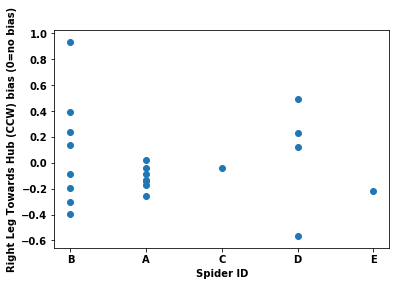

In [219]:
plt.scatter(y=data.biasRightLegTowardHub, x=data.spider)
plt.xlabel('Spider ID')
plt.ylabel('Right Leg Towards Hub (CCW) bias (0=no bias)')

In [209]:
from scipy.stats import kruskal

In [217]:
grps = [data.biasRightLegTowardHub[data.spider==x].values for x in data.spider.unique()]
kruskal(*grps).pvalue

0.6937002284731046

In [221]:
# Source: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.nanmean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

(array([1., 2., 6., 5., 2., 2., 1., 1., 0., 1.]),
 array([-0.56660413, -0.41686131, -0.2671185 , -0.11737569,  0.03236713,
         0.18210994,  0.33185275,  0.48159557,  0.63133838,  0.78108119,
         0.93082401]),
 <a list of 10 Patch objects>)

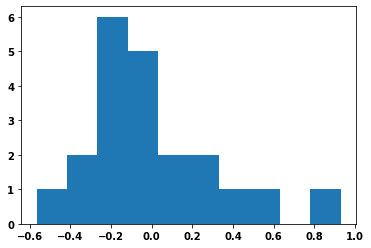

In [220]:
plt.hist(data.biasRightLegTowardHub)

In [233]:
bootstrap(data.biasRightLegTowardHub, 5000, np.nanmedian)(0.95)

(-0.17399529012083542, 0.11848941086435015)

In [234]:
bootstrap(data.biasRightLegTowardHub, 5000, np.nanmean)(0.95)

(-0.1348871009228511, 0.14480644934951553)